In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tank import RectangularTank
from tanksolver import SloshingSolver

In [2]:
def analytical_natural_frequency_and_mode(w, h, m):
    if np.sign(m) > 0:
        # Symmetric mode.
        km = 2*np.abs(m) * np.pi / w
        qmx = lambda x: np.cos(km * x)
    else:
        # Asymmetric mode.
        km = (2*np.abs(m) - 1) * np.pi / w
        qmx = lambda x: np.sin(km * x)

    wm = np.sqrt(g * km * np.tanh(km * h))

    return wm, qmx

In [3]:
w = 1.0
h = 0.5
g = 9.81  # Acceleration of gravity.
RT = RectangularTank(w, h, 5, 4, 10)

In [4]:
# Solution of the eigenvalue problem.
solver = SloshingSolver(RT)
solver.solve_eigenvalue_problem()

In [5]:
# x-coordinates of analytical solution.
xm = np.linspace(-w/2.0, w/2.0, 100)

# x-coordinates of numerical solution.
nf = RT.number_of_free_surface_elements
free_surface_nodes = RT.midpoints[-nf:]
fsx = free_surface_nodes[:, 0]

# Scaling function.
def scale_mode(qm, fsm):
    ratio = qm / fsm
    mask = np.abs(qm) >= np.finfo(np.float64).eps  # Discard points where the mode shape is close to zero.
    scaling_factor = np.mean(ratio[mask])

    return scaling_factor * fsm

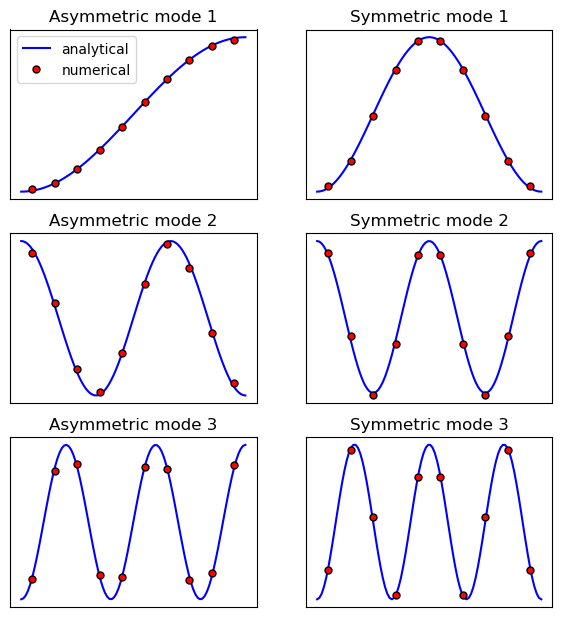

In [6]:
# Plot natural modes.
nmodes = 6  # Number of modes to be plotted.
if nmodes > nf - 1:
    raise ValueError(f"The maximum number of modes that can be plotted is {nf-1}")

nrows = np.ceil(nmodes / 2).astype(np.int32)
figh = nrows * 2.5
fig, ax = plt.subplots(nrows, 2, figsize=(7, figh))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if 2*i+j >= nmodes:
            break

        mode = (i+1) * np.sign(j-0.5)

        _, qmx = analytical_natural_frequency_and_mode(w, h, mode)
        qm = qmx(xm)
        fsm = solver.natural_modes[:, 2*i+j].copy()
        fsm = scale_mode(qmx(fsx), fsm)

        if mode < 0:
            ax[i, j].set_title(f'Asymmetric mode {np.abs(mode).astype(int)}')
        else:
            ax[i, j].set_title(f'Symmetric mode {np.abs(mode).astype(int)}')
        ax[i, j].plot(xm, qm, '-b', label='analytical')
        ax[i, j].plot(fsx, fsm, 'or', markersize=5, markeredgecolor='k', label='numerical')

for e in ax.ravel():
    e.xaxis.set_visible(False)
    e.yaxis.set_visible(False)

ax[0, 0].legend()

plt.savefig('natural_modes.svg', bbox_inches='tight')
plt.show()

In [7]:
# Comparing analytical and numerical natural frequencies.
number_of_modes = 4
w = 1.0
hw_analytical = np.linspace(0.01, 1.5, 100)
natural_frequencies_analytical = np.empty((len(hw_analytical), number_of_modes))
for i, h in enumerate(hw_analytical):
    for j in range(number_of_modes):
        mode = (-1)**(j+1) * np.ceil((j+1)/2)
        wm, _ = analytical_natural_frequency_and_mode(w, h, mode)
        natural_frequencies_analytical[i, j] = wm

hw_numerical = np.linspace(0.01, 1.5, 20)
natural_frequencies_numerical = np.empty((len(hw_numerical), number_of_modes))
for i, h in enumerate(hw_numerical):
    RT = RectangularTank(w, h, 10, 8, 20)
    solver = SloshingSolver(RT)
    solver.solve_eigenvalue_problem()
    natural_frequencies_numerical[i] = solver.natural_frequencies[:number_of_modes]

# Turning into dimensionless expressions.
hw_analytical /= w
hw_numerical /= w
natural_frequencies_numerical *= np.sqrt(w/g)
natural_frequencies_analytical *= np.sqrt(w/g)

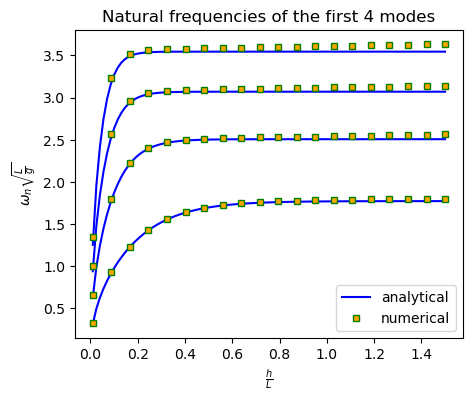

In [8]:
# Plot natural frequencies.
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_title(f"Natural frequencies of the first {number_of_modes} modes")
ax.plot(hw_analytical, natural_frequencies_analytical, '-b', label='analytical')
ax.plot(hw_numerical, natural_frequencies_numerical, 's', mfc='orange', mec='g', markersize=5, label='numerical')
ax.set_xlabel(r'$\frac{h}{L}$')
ax.set_ylabel(r'$\omega_n \sqrt{\frac{L}{g}}$')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.savefig('natural_frequencies.svg', bbox_inches='tight')
plt.show()

In [9]:
# Get experimental natural frequency of the first mode.
experimental_data = np.loadtxt('experimental_data.csv')
hw_experimental = experimental_data[:, 0]
w1_experimental = experimental_data[:, 1]

# Get analytical and numerical natural frequency of the first mode.
w = 1.0
hw = np.linspace(0.01, 1.5, 100)
w1_analytical = np.empty_like(hw)
w1_numerical = np.empty_like(hw)

for i, h in enumerate(hw):
    wm, _ = analytical_natural_frequency_and_mode(w, h, -1)
    w1_analytical[i] = wm

    RT = RectangularTank(w, h, 10, 8, 20)
    solver = SloshingSolver(RT)
    solver.solve_eigenvalue_problem()
    w1_numerical[i] = solver.natural_frequencies[0]

# Turning into dimensionless expressions.
hw /= w
w1_numerical *= np.sqrt(w/g)
w1_analytical *= np.sqrt(w/g)

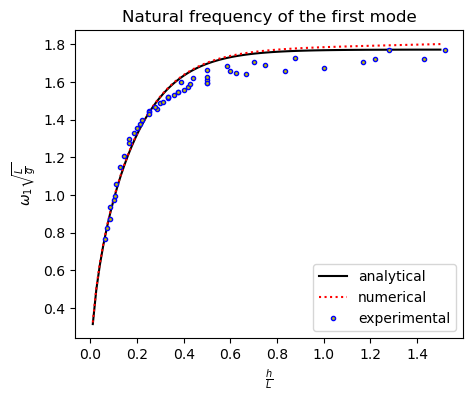

In [10]:
# Plot analytical, numerical and experimental natural frequency of the first mode.
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_title('Natural frequency of the first mode')
ax.plot(hw, w1_analytical, '-k', label='analytical')
ax.plot(hw, w1_numerical, ':r', label='numerical')
ax.plot(hw_experimental, w1_experimental, 'b.', mfc='y', label='experimental')
ax.set_xlabel(r'$\frac{h}{L}$')
ax.set_ylabel(r'$\omega_1 \sqrt{\frac{L}{g}}$')
ax.legend()

plt.savefig('natural_frequency_mode1.svg', bbox_inches='tight')
plt.show()